## Sampling Strategies


As we noticed that the data skewed heavily, we decided to use some sampling strategies to balance the dataset. The method we took included:

1. **Original distribution sampling**: leveraging the multi-label stratified shuffle split functions provided by `iterstrat` library, we directly sampled the original distribution of the dataset. This sampling strategy is mainly used for verifying whether the skewed dataset will affect the model performance.

2. **Round-robin sampling**: we sampled one instance from each label in a round-robin fashion until we reach the desired number of samples. When the number of samples of one label is expired, we will skip this label and continue sampling from the remaining labels. We used this method to try to sample the data samples as balanced as possible.

3. **Rare-first sampling**: this method is used to sample the labels from the dataset in a rare-first manner. This means that we will sample the rarest label first. As the "No Finding" label samples take roughly 50% of the dataset, and belonged samples actually may not help the model to learn so much. Through this method, we hope the model can pay more attention to the rare labels.

4. **Binary sampling**: as we want to leverage the generative models to do abnormality detection, we relabeled the dataset to binary labels. The samples with "No Finding" label are relabeled to 0, and the samples with other labels are relabeled to 1. This method is used to verify whether the generative models can learn the distribution of the normal samples.

We trained the models with the above sampling strategies and evaluated the performance of the models on the test set, to compare the performance of different kinds of deep learning models, and how will the sampling strategies affect the model performance. The different sampling strategies also served as a data augmentation method to increase the diversity of the training set in our project.

For each sampling strategy, the dataset is split into 80% for training (20k samples), 10% for validation (2.5k samples), and 10% for testing (2.5k samples). The training set is used to train the model, the validation set is used to avoid overfitting and trigger early stopping, and the test set is used to evaluate the model performance.

Here we utilized the following visualization function to show the relative distribution of the labels in the preprocessed dataset under different sampling strategies.

In [1]:
import os
import os.path as osp
import random
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

%matplotlib inline

def show_split_distribution(train_df, val_df, test_df, original_df=None, save_name=None):
    """
    Visualizes the relative percentage distribution of labels across train, validation and test sets.
    """
    # Function to count labels in a dataframe
    def count_labels(df):
        label_counts = defaultdict(int)
        for labels in df['Finding Labels']:
            for label in labels:
                label_counts[label] += 1
        return label_counts
    # Count labels in each split
    train_counts = count_labels(train_df)
    val_counts = count_labels(val_df)
    test_counts = count_labels(test_df)
    # If original dataset is provided, count those labels too
    if original_df is not None:
        # Ensure 'Finding Labels' are lists
        if isinstance(original_df["Finding Labels"].iloc[0], str):
            orig_df_copy = original_df.copy()
            orig_df_copy["Finding Labels"] = orig_df_copy["Finding Labels"].str.split('|')
        else:
            orig_df_copy = original_df
        orig_counts = count_labels(orig_df_copy)
    # Get all unique labels
    all_labels = set()
    for counts in [train_counts, val_counts, test_counts]:
        all_labels.update(counts.keys())
    all_labels = sorted(list(all_labels))
    # Prepare data for plotting
    train_values = [train_counts.get(label, 0) for label in all_labels]
    val_values = [val_counts.get(label, 0) for label in all_labels]
    test_values = [test_counts.get(label, 0) for label in all_labels]
    # Calculate percentages
    train_size = sum(train_values)
    val_size = sum(val_values)
    test_size = sum(test_values)
    train_pct = [count/train_size*100 for count in train_values]
    val_pct = [count/val_size*100 for count in val_values]
    test_pct = [count/test_size*100 for count in test_values]
    # For original dataset if provided
    if original_df is not None:
        orig_values = [orig_counts.get(label, 0) for label in all_labels]
        orig_size = sum(orig_values)
        orig_pct = [count/orig_size*100 for count in orig_values]
    # Setup for plot
    plt.figure(figsize=(15, 6))
    x = np.arange(len(all_labels))
    width = 0.2
    plt.bar(x - width*1.5, train_pct, width, label='Train')
    plt.bar(x - width/2, val_pct, width, label='Validation')
    plt.bar(x + width/2, test_pct, width, label='Test')
    if original_df is not None:
        plt.bar(x + width*1.5, orig_pct, width, label='Original')
    plt.ylabel('Percentage (%)')
    plt.title('Relative Label Distribution')
    plt.xticks(x, all_labels, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    if save_name:
        save_dir = "imgs"
        if not osp.exists(save_dir):
            os.makedirs(save_dir)
        save_path = osp.join(save_dir, save_name)
        plt.savefig(save_path)
    else:
        plt.show()
    # Print summary statistics
    print("Dataset sizes:")
    print(f"Train: {len(train_df)} samples with {sum(train_values)} labels (avg {sum(train_values)/len(train_df):.2f} labels per sample)")
    print(f"Validation: {len(val_df)} samples with {sum(val_values)} labels (avg {sum(val_values)/len(val_df):.2f} labels per sample)")
    print(f"Test: {len(test_df)} samples with {sum(test_values)} labels (avg {sum(test_values)/len(test_df):.2f} labels per sample)")
    if original_df is not None:
        print(f"Original: {len(original_df)} samples with {sum(orig_values)} labels (avg {sum(orig_values)/len(original_df):.2f} labels per sample)")


### Original Distribution Sampling

To implement the original distribution sampling, we used the `MultiLabelStratifiedShuffleSplit` function from the `iterstrat` library. This function allows us to split the dataset into training, validation, and test sets while preserving the original label distribution.

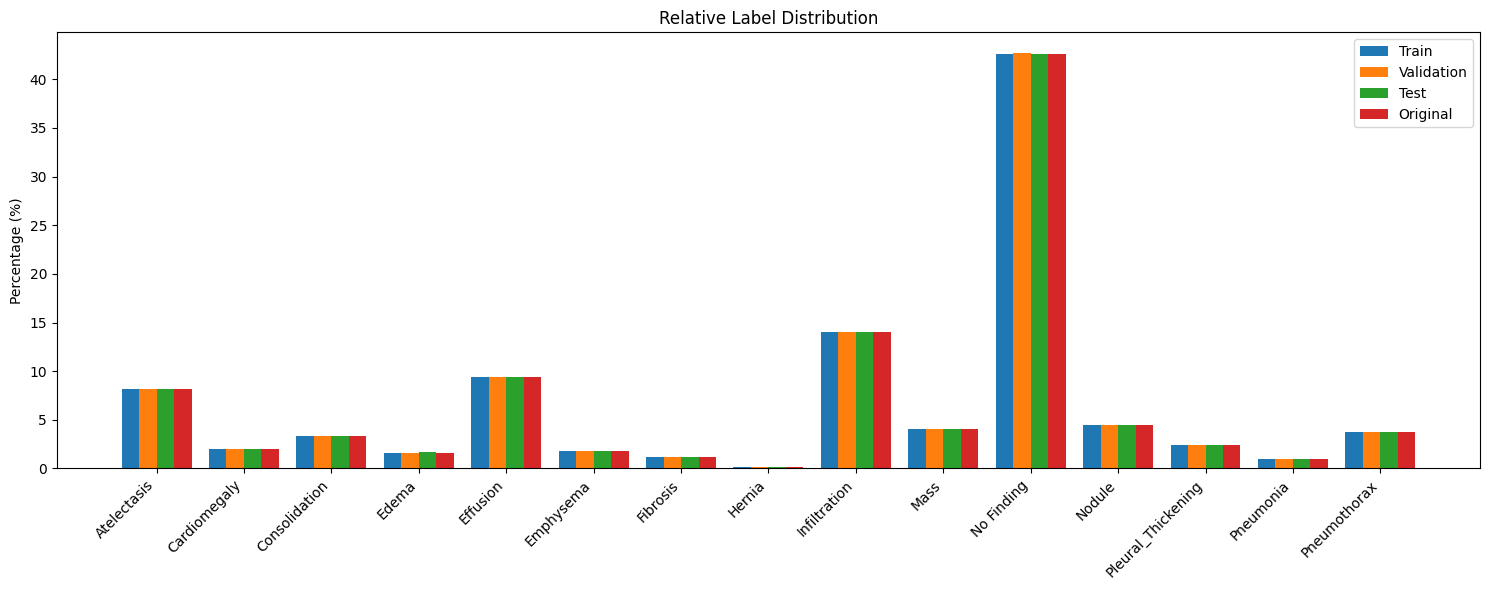

Dataset sizes:
Train: 19989 samples with 25249 labels (avg 1.26 labels per sample)
Validation: 2516 samples with 3153 labels (avg 1.25 labels per sample)
Test: 2505 samples with 3158 labels (avg 1.26 labels per sample)
Original: 112120 samples with 141537 labels (avg 1.26 labels per sample)


In [2]:
def multilabel_split(df, train_size=20000, val_size=2500, test_size=2500, seed=42):
    random.seed(seed)
    df = df[["Image Index", "Finding Labels"]].copy()
    if isinstance(df["Finding Labels"].iloc[0], str):
        df["Finding Labels"] = df["Finding Labels"].str.split("|")
    # Binarize the labels
    mlb = MultiLabelBinarizer()
    Y_full = mlb.fit_transform(df["Finding Labels"])   # (N, L)
    idx_full = df.index.to_numpy()
    total = len(df)
    subsz = train_size + val_size + test_size
    # Select a stratified subsample of the desired total size from the full dataset
    msss0 = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        train_size=subsz / total,
        test_size=(total - subsz) / total,
        random_state=seed
    )
    sub_i, _ = next(msss0.split(idx_full, Y_full))
    df_sub = df.iloc[sub_i].reset_index(drop=True)
    Y_sub  = Y_full[sub_i]
    # Split the subsample into training and temporary (validation + test) sets
    msss1 = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        train_size=train_size / subsz,
        test_size=(val_size + test_size) / subsz,
        random_state=seed
    )
    tr_i, tmp_i = next(msss1.split(df_sub.index.to_numpy(), Y_sub))
    df_train = df_sub.iloc[tr_i].reset_index(drop=True)
    df_tmp   = df_sub.iloc[tmp_i].reset_index(drop=True)
    Y_tmp    = Y_sub[tmp_i]
    # Split the temporary set into validation and test sets
    msss2 = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        train_size=val_size / (val_size + test_size),
        test_size=test_size / (val_size + test_size),
        random_state=seed
    )
    v_i, te_i = next(msss2.split(df_tmp.index.to_numpy(), Y_tmp))
    df_val  = df_tmp.iloc[v_i].reset_index(drop=True)
    df_test = df_tmp.iloc[te_i].reset_index(drop=True)
    return df_train, df_val, df_test

df = pd.read_csv("data/Data_Entry_2017.csv")
train_df, val_df, test_df = multilabel_split(df)
show_split_distribution(train_df, val_df, test_df, df)

From the figure above, we can see that the original distribution of the dataset is heavily skewed towards the "No Finding" label, which takes up about 50% of the dataset. The other labels are much less frequent, with some labels having only a few samples. Using the original distribution sampling strategy, all labels preserved their original distribution in the training, validation, and test sets.

### Round-Robin Sampling

To make the dataset more balanced, we implemented a round-robin sampling strategy. This method samples one instance from each label in a round-robin fashion until we reach the desired number of samples. The round-robin sampling strategy helps to ensure that each label is represented in the training set, even if some labels are rare. We implemented this strategy using the below code snippet.

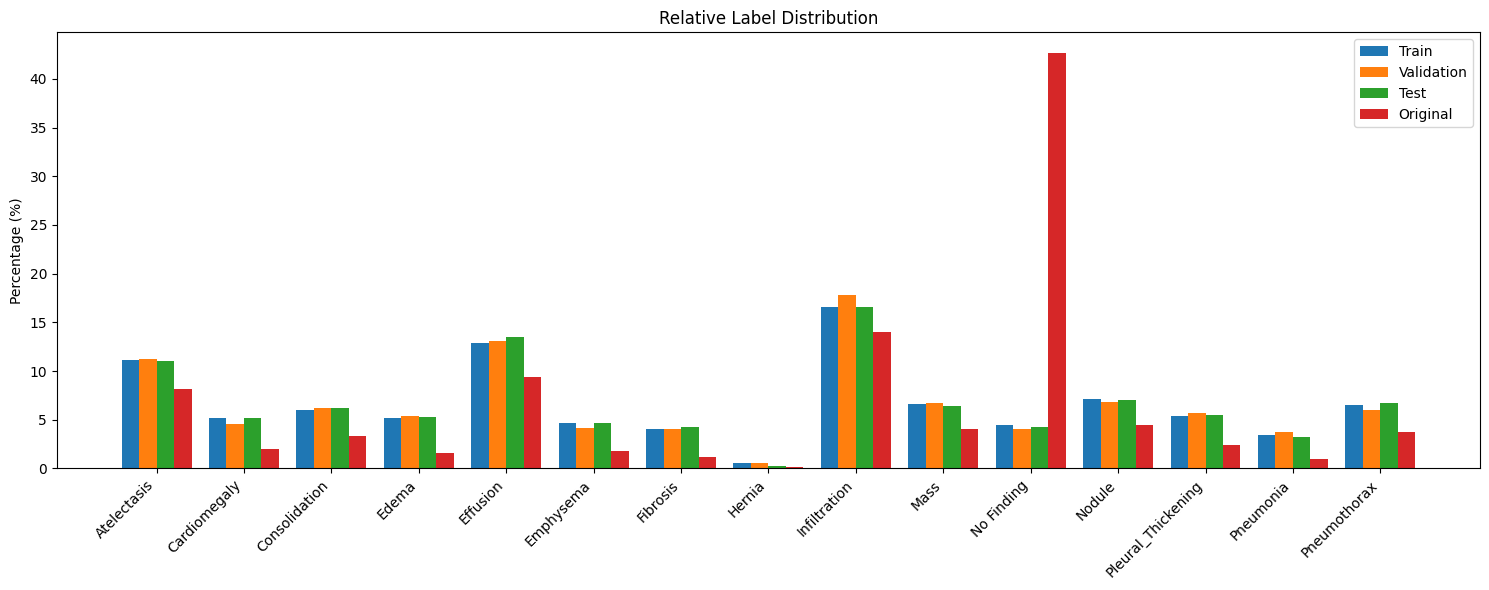

Dataset sizes:
Train: 20000 samples with 32886 labels (avg 1.64 labels per sample)
Validation: 2500 samples with 4222 labels (avg 1.69 labels per sample)
Test: 2500 samples with 4143 labels (avg 1.66 labels per sample)
Original: 112120 samples with 141537 labels (avg 1.26 labels per sample)


In [3]:
def multilabel_balanced_split(df, train_size=20000, val_size=2500, test_size=2500, seed=42):
    """
    Splits a multilabel dataset into balanced training, validation, and test sets.

    This function attempts to ensure that each label is represented as evenly as possible across the splits,
    by iteratively sampling indices associated with each label until the desired split sizes are reached.
    """
    random.seed(seed)
    df = df[["Image Index", "Finding Labels"]].copy()
    if isinstance(df["Finding Labels"].iloc[0], str):
        df["Finding Labels"] = df["Finding Labels"].str.split('|')
    total_size = train_size + val_size + test_size
    # Construct a mapping of labels to their indices
    label2idxs = defaultdict(list)
    for idx, row in df.iterrows():
        for label in row['Finding Labels']:
            label2idxs[label].append(idx)
    labels = list(label2idxs.keys())
    # Records the index of the last sampled item for each label
    label_ptr = {l: 0 for l in labels}
    # Main sampling loop
    sampled_idx = set()
    last_sampled_count = 0
    cut_pos = []
    newly_sampled_idx = []
    total_idxs = set(range(len(df)))
    while len(sampled_idx) < total_size:
        for label in labels:
            ptr = label_ptr[label]
            total_label_idx = label2idxs[label]
            # Skip labels that have been fully traversed
            if ptr >= len(total_label_idx):
                continue
            while ptr < len(total_label_idx):
                xi = total_label_idx[ptr]
                ptr += 1
                if xi not in sampled_idx:
                    sampled_idx.add(xi)
                    newly_sampled_idx.append(xi)
                    break
            label_ptr[label] = ptr
        # Check if have exhausted all labels
        any_exhausted = False
        for l in labels:
            if label_ptr[l] >= len(label2idxs[l]):
                any_exhausted = True
                break
        if any_exhausted or len(sampled_idx) >= total_size:
            # Record the cut point
            cut_pos.append((last_sampled_count, len(sampled_idx)))
            last_sampled_count = len(sampled_idx)
    # Fill in the remaining samples
    remaining_needed = total_size - len(sampled_idx)
    if remaining_needed > 0:
        remain_pool = list(total_idxs - sampled_idx)
        random.shuffle(remain_pool)
        for xi in remain_pool[:remaining_needed]:
            sampled_idx.add(xi)
            newly_sampled_idx.append(xi)
        if remaining_needed > 0:
            cut_pos.append((last_sampled_count, len(sampled_idx)))
            last_sampled_count = len(sampled_idx)
    # Assign the sampled indices to the corresponding dataset
    sampled_idx_list = list(sampled_idx)
    random.shuffle(sampled_idx_list)
    train_ids = sampled_idx_list[:train_size]
    val_ids = sampled_idx_list[train_size: train_size + val_size]
    test_ids = sampled_idx_list[train_size + val_size: train_size + val_size + test_size]
    train_df = df.loc[train_ids].reset_index(drop=True)
    val_df = df.loc[val_ids].reset_index(drop=True)
    test_df = df.loc[test_ids].reset_index(drop=True)
    return train_df, val_df, test_df

df = pd.read_csv("data/Data_Entry_2017.csv")
train_df, val_df, test_df = multilabel_balanced_split(df)
show_split_distribution(train_df, val_df, test_df, df)

Through this method, we can see that the distribution of the labels in the training set is much more balanced compared to the original distribution. The round-robin sampling strategy ensures that each label is represented in the training set, which can help the model learn better representations for all labels.

### Rare-First Sampling

As rare diseases are often overlooked, but important to detect, we implemented a rare-first sampling strategy. This method samples the rarest label first, ensuring that the model pays more attention to the rare labels. The rare-first sampling strategy is implemented using the below code snippet.

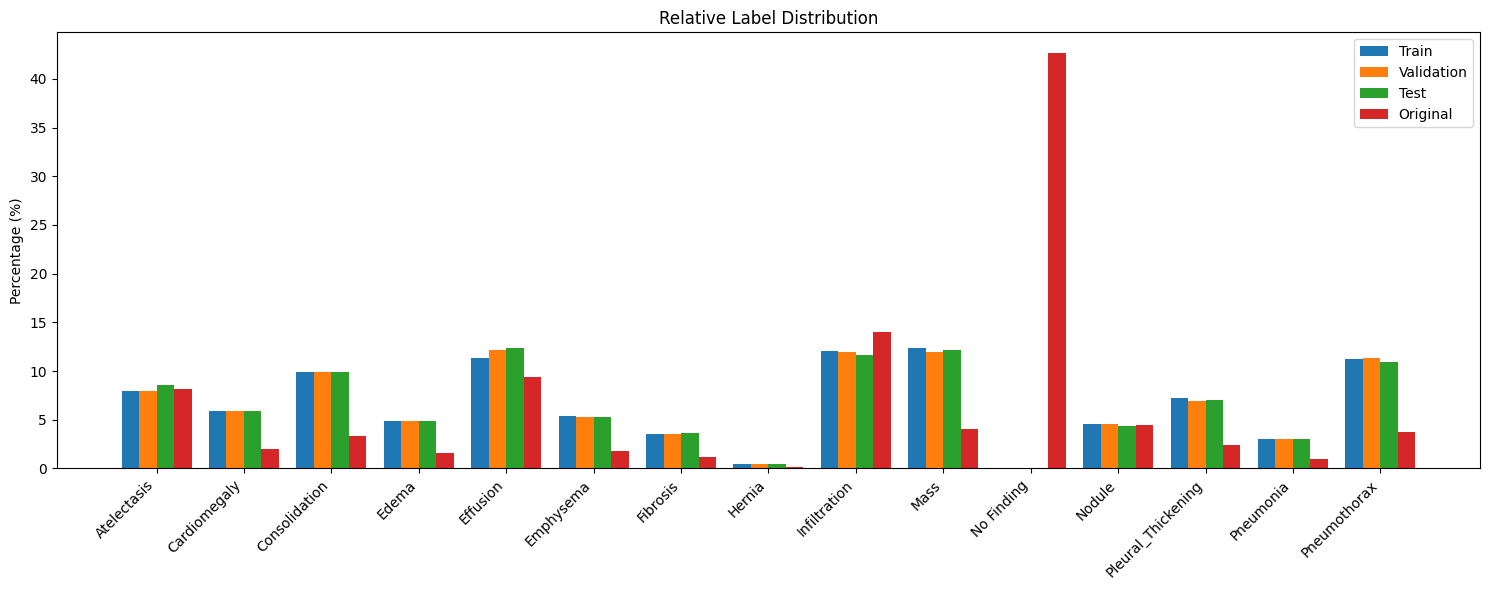

Dataset sizes:
Train: 20000 samples with 37641 labels (avg 1.88 labels per sample)
Validation: 2500 samples with 4684 labels (avg 1.87 labels per sample)
Test: 2500 samples with 4749 labels (avg 1.90 labels per sample)
Original: 112120 samples with 141537 labels (avg 1.26 labels per sample)


In [4]:
def multilabel_rare_first_split(df, train_size=20000, val_size=2500, test_size=2500, seed=42):
    """
    Splits a multilabel dataset into train, validation, and test sets, prioritizing rare labels.

    This function ensures that images containing rare labels are assigned to splits first, 
    helping to maximize the representation of infrequent labels in all splits.
    """
    random.seed(seed)
    df = df[["Image Index", "Finding Labels"]].copy()
    if isinstance(df['Finding Labels'].iloc[0], str):
        df['Finding Labels'] = df['Finding Labels'].str.split('|')
    # Count label frequencies
    label_counter = Counter(label for labels in df['Finding Labels'] for label in labels)
    sorted_labels = sorted(label_counter.items(), key=lambda x: x[1])  # rarest first
    # Build mapping
    image_labels = dict(zip(df['Image Index'], df['Finding Labels']))
    label_to_images = defaultdict(set)
    for img, labels in image_labels.items():
        for label in labels:
            label_to_images[label].add(img)
    # Sets to track assignment
    train_images = set()
    val_images = set()
    test_images = set()
    used_images = set()
    def add_image(img, split):
        if img not in used_images:
            if split == "train":
                train_images.add(img)
            elif split == "val":
                val_images.add(img)
            elif split == "test":
                test_images.add(img)
            used_images.add(img)
    total_needed = train_size + val_size + test_size
    for label, _ in sorted_labels:
        candidate_images = list(label_to_images[label] - used_images)
        random.shuffle(candidate_images)
        n_total = len(candidate_images)
        # Skip if we've hit capacity
        if len(train_images) >= train_size and len(val_images) >= val_size and len(test_images) >= test_size:
            break
        remaining_train = train_size - len(train_images)
        remaining_val = val_size - len(val_images)
        remaining_test = test_size - len(test_images)
        available = min(n_total, remaining_train + remaining_val + remaining_test)
        if available == 0:
            continue
        n_train = int(available * (train_size / total_needed))
        n_val = int(available * (val_size / total_needed))
        n_test = available - n_train - n_val
        # Adjust to stay within global limits
        n_train = min(n_train, remaining_train)
        n_val = min(n_val, remaining_val)
        n_test = min(n_test, remaining_test)
        idx = 0
        for img in candidate_images[idx:idx + n_train]:
            add_image(img, "train")
        idx += n_train
        for img in candidate_images[idx:idx + n_val]:
            add_image(img, "val")
        idx += n_val
        for img in candidate_images[idx:idx + n_test]:
            add_image(img, "test")
    # If not enough images, fill randomly from unused
    all_images = set(df["Image Index"])
    unused_images = list(all_images - used_images)
    random.shuffle(unused_images)
    while len(train_images) < train_size and unused_images:
        add_image(unused_images.pop(), "train")
    while len(val_images) < val_size and unused_images:
        add_image(unused_images.pop(), "val")
    while len(test_images) < test_size and unused_images:
        add_image(unused_images.pop(), "test")
    # Build DataFrames
    train_df = df[df["Image Index"].isin(train_images)].reset_index(drop=True)
    val_df = df[df["Image Index"].isin(val_images)].reset_index(drop=True)
    test_df = df[df["Image Index"].isin(test_images)].reset_index(drop=True)
    return train_df, val_df, test_df

df = pd.read_csv("data/Data_Entry_2017.csv")
train_df, val_df, test_df = multilabel_rare_first_split(df)
show_split_distribution(train_df, val_df, test_df, df)

As shown in the figure, the rare-first sampling strategy ensures that the rare labels are represented in the splits. However, the "No Finding" label is excluded, due to its high prevalence in the dataset. This sampling strategy can help the model learn better representations for the rare labels, which can be important for detecting rare diseases, while still allowing the dataset to be balanced.

### Binary Sampling

To leverage the generative models for abnormality detection, we relabeled the dataset to binary labels. The samples with "No Finding" label are relabeled to 0, and the samples with other labels are relabeled to 1. This method is used to verify whether the generative models can learn the distribution of the normal samples. As there are only two labels in the dataset, we did not provide the visualization for this sampling strategy.

For the size of the dataset, we still used 20k samples for training, to ensure that the comparison is fair across different deep learning models. And we used 2.5k normal samples and 2.5k abnormal samples for the testing.

In [ ]:
def binary_split(df, train_size=20000, test_normal_size=2500, test_abnormal_size=2500, seed=42):
    """
    Splits a DataFrame containing medical findings into training and test sets for binary classification.
    """
    random.seed(seed)
    df = df[["Image Index", "Finding Labels"]].copy()
    if isinstance(df["Finding Labels"].iloc[0], str):
        df["Finding Labels"] = df["Finding Labels"].str.split('|')
    # Ensure 'binary_label' column exists
    if 'binary_label' not in df.columns:
        df['binary_label'] = df['Finding Labels'].apply(lambda labels: 0 if labels == ['No Finding'] else 1)
    # Separate into normal and abnormal
    df_normal = df[df['binary_label'] == 0].copy()
    df_abnormal = df[df['binary_label'] == 1].copy()
    # Shuffle both datasets
    df_normal = df_normal.sample(frac=1, random_state=seed).reset_index(drop=True)
    df_abnormal = df_abnormal.sample(frac=1, random_state=seed).reset_index(drop=True)
    # Check if we have enough data
    if len(df_normal) < train_size:
        raise ValueError(f"Not enough normal samples: have {len(df_normal)}, need {train_size}")
    if len(df_abnormal) < (test_normal_size + test_abnormal_size):
        raise ValueError(f"Not enough abnormal samples: have {len(df_abnormal)}, need {test_normal_size, test_abnormal_size}")
    # Create the splits
    train_df = df_normal.iloc[:train_size].reset_index(drop=True)
    test_normal_df = df_normal.iloc[train_size:train_size+test_normal_size].reset_index(drop=True)
    test_abnormal_df = df_abnormal.iloc[:test_abnormal_size].reset_index(drop=True)
    return train_df, test_normal_df, test_abnormal_df

## Preprocessing and Data Analysis

### Dataset Preprocessing

Due to the high resolution of the original images and computation resource limitations, we resized the images to $224 \times 224$ pixels. This resizing helps in reducing the computational load and improving processing time for subsequent analysis. Additionally, to deal with the multi-label nature of the dataset, we used the multi-hot encoding technique to convert the labels into a binary format. We preprocessed the dataset using the below code snippet.

In [ ]:
import os
import os.path as osp
from glob import glob
import argparse
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

def collect_image_paths(root_dir):
    """
    Collect all image paths from the dataset.
    """
    image_dict = {}
    folders = glob(os.path.join(root_dir, 'images_*', 'images'))
    for folder in folders:
        all_images = glob(os.path.join(folder, '*.png'))
        for path in all_images:
            name = os.path.basename(path)
            image_dict[name] = path
    return image_dict

def convert_img_to_tensor(split_df, image_dict, save_root, split_type):
    """
    Convert images to tensor format and save them.
    """
    output_size = 224
    save_dir = osp.join(save_root, split_type)
    os.makedirs(save_dir, exist_ok=True)
    indices = split_df["Image Index"].values.tolist()
    if len(indices) == 0:
        torch.save(torch.empty((0, 1, output_size, output_size)), osp.join(save_dir, "images.pt"))
    tensor_list = []
    transform = transforms.Compose([
        transforms.Resize((output_size, output_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    for i in tqdm(range(len(indices)), desc=f"Converting {split_type} images"):
        image = indices[i]
        path = image_dict[image]
        img = Image.open(path).convert("L")
        tensor = transform(img)
        tensor_list.append(tensor)
    tensors = torch.stack(tensor_list)
    torch.save(tensors, osp.join(save_dir, "images.pt"))

def convert_label_to_tensor(split_df, label_dict, save_root, split_type):
    """
    Convert labels to tensor format and save them.
    """
    save_dir = osp.join(save_root, split_type)
    os.makedirs(save_dir, exist_ok=True)
    lbl_series = split_df["Finding Labels"].tolist()
    num_samples = len(lbl_series)
    num_classes = len(label_dict)
    if num_samples == 0:
        # Deal with empty dataset
        empty = torch.empty((0, num_classes), dtype=torch.float32)
        torch.save(empty, osp.join(save_dir, "labels.pt"))
        return
    tensor_list = []
    for lbls in tqdm(lbl_series, desc=f"Converting {split_type} labels"):
        # Multi-hot encoding for multi-label classification
        mh = torch.zeros(num_classes, dtype=torch.float32)
        for l in lbls:
            if l and l in label_dict:
                mh[label_dict[l]] = 1.0
        tensor_list.append(mh)
    labels_tensor = torch.stack(tensor_list)
    torch.save(labels_tensor, osp.join(save_dir, "labels.pt"))

Taking the round-robin sampling strategy function above as an example, we leveraged the following code snippet to preprocess the dataset.

In [ ]:
# Split the dataset, can change the split method as needed
train_df, val_df, test_df = multilabel_balanced_split(df)
# Generate unified label dict from all Finding Labels
label_dict = None
all_labels = set()
for item in df["Finding Labels"].tolist():
    lbls = item.split("|")
    all_labels.update([l for l in lbls if l])
all_labels = sorted(all_labels)
label_dict = {label: idx for idx, label in enumerate(all_labels)}
# Save label dict to a file
label_dict_path = os.path.join("data_tensor", "label_dict.txt")
with open(label_dict_path, "w") as f:
    for label, idx in label_dict.items():
        f.write(f"{label}: {idx}\n")
# Collect image paths
image_dict = collect_image_paths("data")
# Convert images into tensor format
convert_img_to_tensor(train_df, image_dict, "data_tensor", "train")
convert_img_to_tensor(val_df, image_dict, "data_tensor", "val")
convert_img_to_tensor(test_df, image_dict, "data_tensor", "test")
# Convert labels into tensor format
convert_label_to_tensor(train_df, label_dict, "data_tensor", "train")
convert_label_to_tensor(val_df, label_dict, "data_tensor", "val")
convert_label_to_tensor(test_df, label_dict, "data_tensor", "test")

Converting test labels: 100%|██████████| 2500/2500 [00:00<00:00, 89054.82it/s]


### Evaluation Metrics

In practical applications of deep learning models in the medical domain, it is essential to evaluate model performance using appropriate metrics. Due to the critical nature of medical responsibilities and the need for rigorous diagnostic standards, it is widely accepted that models should accurately detect abnormalities and defer the final diagnosis to human experts. This collaborative approach ensures reliable outcomes and upholds the highest standards of patient care.

In this project, we adhere to this guiding principle. The model outputs a probability vector matching the shape of the multi-hot encoded labels, where each bit corresponds to a specific disease. If the probability for the **"No Finding"** label exceeds 0.5, the sample is classified as normal; otherwise, it is considered abnormal.

Formally, a sample is labeled **negative** (i.e., normal) if the "No Finding" probability is greater than 0.5, and **positive** (i.e., abnormal) otherwise.

We use the following metrics to evaluate model performance when evaluating and comparing the performance of different models:

1. **Accuracy**: The proportion of correctly predicted positive and negative samples out of all samples.

2. **Recall**: The proportion of correctly predicted positive samples out of all actual positive samples.

Both metrics are important for assessing model performance. And in medical applications, recall is particularly critical to minimize the risk of missing abnormal cases.

### Training Managements

Though the evaluation of the models is based on a binary classification concept, for the training process, we still used the multi-label classification loss function. The loss function is calculated using the binary cross-entropy loss function, which is suitable for multi-label classification tasks. The loss function is defined as follows:

$$ \mathcal{L} = -\frac{1}{N \cdot C} \sum\limits_{n=1}^{N} \sum\limits_{c=1}^{C} \left[ y_{n,c} \cdot \log(p_{n,c}) + (1 - y_{n,c}) \cdot \log(1 - p_{n,c}) \right] $$

where $N$ is the number of samples, $C$ is the number of classes, $y_{n,c}$ is the true label of the sample $n$ for class $c$, and $p_{n,c}$ is the predicted probability of the sample $n$ for class $c$. In the detailed implementation, we used the `BCEWithLogitsLoss` function from the `torch.nn` module, which combines a sigmoid layer and the binary cross-entropy loss in one single class. This function is numerically more stable than using a plain Sigmoid followed by a BCELoss.

Due to the large size of the dataset, and to make the training process more efficient and manageable, for all the models mentioned below, we used a unified Python script to train them. In the following sections, we may only provide the used code snippets and the test results with the trained models, but without the output within the Jupyter Notebook and log contents. The Python script is available at the [GitHub repository](https://github.com/yanming-s/CS5242_Project), and is totally reproducible.

Following is an example full training script for the Vision Transformer (ViT) model.

In [ ]:
import os
import os.path as osp
import argparse
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from time import time
import warnings

from models.vit import ViT
from models.vit_pre import ViT_Pre
from dataset.dataloader import get_multilabel_dataloader
from dataset.lazy_dataloader import get_lazy_dataloader

warnings.filterwarnings("ignore", category=UserWarning)


def train_one_epoch(model, loader, criterion, optimizer, max_grad_norm, device, epoch):
    model.train()
    running_loss = 0.0
    start = time()
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        running_loss += loss.item()
    duration = time() - start
    avg_loss = running_loss / len(loader)
    logging.info(f"epoch {epoch} - loss {avg_loss:.4f} - time {duration:.2f}s")
    return avg_loss


@torch.no_grad()
def validate(model, loader, criterion, device, split):
    model.eval()
    running_loss = 0.0
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
    avg_loss = running_loss / len(loader)
    logging.info(f"{split} loss {avg_loss:.4f}")
    return avg_loss


@torch.no_grad()
def test(model, loader, device, label_dict_path):
    """
    Calculate overall accuracy and recall for the disease class,
    using the 'No Finding' label bit to distinguish normal vs. abnormal.
    """
    model.eval()
    # Load and parse label dictionary into a name→index map
    with open(label_dict_path, "r") as f:
        lines = f.read().splitlines()
    label_to_idx = {}
    for line in lines:
        name, idx = line.split(":")
        label_to_idx[name.strip()] = int(idx.strip())
    # Get index of the 'No Finding' (normal) class
    no_find_idx = label_to_idx["No Finding"]
    # Prepare counters
    total_samples = 0
    correct_preds = 0
    true_positive = 0    # correctly predicted diseased
    false_negative = 0   # diseased samples predicted as normal
    sigmoid = nn.Sigmoid()
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)
        # Model outputs logits for each class
        outputs = model(images)
        probs = sigmoid(outputs)
        # Predicted normal if P(No Finding) >= 0.5
        pred_normal = probs[:, no_find_idx] >= 0.5
        # Ground-truth normal where target bit is 1
        actual_normal = targets[:, no_find_idx] == 1
        # Update accuracy count
        correct_preds += (pred_normal == actual_normal).sum().item()
        total_samples += targets.size(0)
        # For disease (positive) samples (actual_normal == False)
        disease_mask = ~actual_normal
        # Predicted disease if not predicted normal
        pred_disease = ~pred_normal
        true_positive += (disease_mask & pred_disease).sum().item()
        false_negative += (disease_mask & pred_normal).sum().item()
    # Compute metrics
    accuracy = correct_preds / total_samples if total_samples > 0 else 0.0
    recall = (true_positive / (true_positive + false_negative)
              if (true_positive + false_negative) > 0 else 0.0)
    # Log results
    logging.info(f"Test Accuracy: {accuracy * 100:.3f}")
    logging.info(f"Disease Recall: {recall * 100:.3f}")


def main():
    # Parse command line arguments
    parser = argparse.ArgumentParser(description="Train ViT on multi-label classification")
    parser.add_argument("--img_size", type=int, default=224, help="Input image size")
    parser.add_argument("--ckpt_dir", type=str, default="checkpoints", help="Checkpoint directory")
    parser.add_argument("--save_every", type=int, default=10, help="Save checkpoint every N epochs")
    parser.add_argument("--epochs", type=int, default=50, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=32, help="Batch size")
    parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument("--index", type=int, default=0, help="GPU device ID")
    parser.add_argument("--use_pretrained", action="store_true", help="Use pretrained model")
    parser.add_argument("--seed", type=int, default=42, help="Random seed for reproducibility")
    parser.add_argument("--test_only", action="store_true", help="Test only without training")
    parser.add_argument("--ckpt_path", type=str, default=None, help="Absolute path to the checkpoint for testing")
    parser.add_argument(
        "--split_type",
        type=str,
        default="balanced",
        choices=["balanced", "rare_first", "original", "binary"],
        help="Split type for dataset"
    )
    args = parser.parse_args()
    # Set logging configuration
    log_dir = osp.join(
        "logs",
        datetime.now().strftime("%Y-%m-%d"),
    )
    os.makedirs(log_dir, exist_ok=True)
    log_file = osp.join(
        log_dir,
        f"vit{'-pretrained' if args.use_pretrained else ''}" + f"{'-test' if args.test_only else ''}" +\
            f"-{args.split_type}-{datetime.now().strftime('%H-%M-%S')}.log"
    )
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s: %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        handlers=[
            logging.FileHandler(log_file, mode='w'),
            logging.StreamHandler()
        ]
    )
    
    # Get data loaders
    logging.info("Loading data...")
    torch.manual_seed(args.seed)
    if args.img_size == 224:
        data_dir = "data_224"
        if not os.path.exists(data_dir):
            data_dir = "data_tensor"
        train_loader = get_multilabel_dataloader(
            data_dir,
            split_type=args.split_type,
            split="train",
            batch_size=args.batch_size,
            shuffle=True
        )
        val_loader = get_multilabel_dataloader(
            data_dir,
            split_type=args.split_type,
            split="val",
            batch_size=args.batch_size,
            shuffle=False
        )
        test_loader = get_multilabel_dataloader(
            data_dir,
            split_type=args.split_type,
            split="test",
            batch_size=args.batch_size,
            shuffle=False
        )
    elif args.img_size == 1024:
        data_dir = "data_1024"
        train_loader = get_lazy_dataloader(
            data_dir,
            split_type=args.split_type,
            split="train",
            chunk_size=32,
            max_chunks_in_ram=25,
            batch_size=args.batch_size,
            shuffle=True
        )
        val_loader = get_lazy_dataloader(
            data_dir,
            split_type=args.split_type,
            split="val",
            chunk_size=32,
            max_chunks_in_ram=25,
            batch_size=args.batch_size,
            shuffle=False
        )
        test_loader = get_lazy_dataloader(
            data_dir,
            split_type=args.split_type,
            split="test",
            chunk_size=32,
            max_chunks_in_ram=25,
            batch_size=args.batch_size,
            shuffle=False
        )
    else:
        raise ValueError("Invalid image size. Choose either 224 or 1024.")
        
    # Initialize model, loss function, and optimizer
    logging.info("Initializing model...")
    device = torch.device(args.device)
    if args.device == "cuda":
        device = torch.device(f"cuda:{args.index}")
        torch.cuda.set_device(args.index)
    if args.use_pretrained:
        model_args = {
            "img_size": args.img_size,
            "in_channels": 1,
            "num_classes": 15,
            "embed_dim": 768,
            "depth": 12,
            "num_heads": 12,
            "mlp_ratio": 4.0,
            "dropout": 0.0,
            "use_pretrained_blocks": True
        }
        model = ViT_Pre(**model_args).to(device)
    else:
        model_args = {
            "img_size": args.img_size,
            "patch_size": 16,
            "in_channels": 1,
            "num_classes": 15,
            "embed_dim": 768,
            "depth": 12,
            "num_heads": 12,
            "mlp_dim": 768 * 4,
            "dropout": 0.0
        }
        model = ViT(**model_args).to(device)
    if args.ckpt_path:
        model.load_state_dict(torch.load(args.ckpt_path))
        logging.info(f"Loaded model from {args.ckpt_path}")
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
    max_grad_norm = 1.0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True
    )
    
    # Main training loop
    if not args.test_only:
        logging.info("Starting training...")
        best_val_loss = float("inf")
        no_improve_epochs = 0
        early_stop_patience = 10
        ckpt_dir = osp.join(args.ckpt_dir, f"vit{'-pretrained' if args.use_pretrained else ''}"+\
                            f"-{args.split_type}-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}")
        os.makedirs(ckpt_dir, exist_ok=True)
        for epoch in range(1, args.epochs + 1):
            train_one_epoch(model, train_loader, criterion, optimizer, max_grad_norm, device, epoch)
            # Gradually improve the gradient clipping threshold
            if epoch > 10:
                max_grad_norm = min(max_grad_norm + 0.1, 5.0)

            val_loss = validate(model, val_loader, criterion, device, "val")
            scheduler.step(val_loss)
            # Early stopping if no improvement or learning rate is too low
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve_epochs = 0
                torch.save(
                    model.state_dict(),
                    osp.join(ckpt_dir, "best_model.pt")
                )
                logging.info(f"Best model saved at epoch {epoch} with val loss {val_loss:.4f}")
            else:
                no_improve_epochs += 1
            current_lr = optimizer.param_groups[0]['lr']
            if no_improve_epochs >= early_stop_patience or current_lr < 1e-6:
                logging.info(f"Early stopping triggered at epoch {epoch}.")
                break

            # Periodic checkpoint saving
            if epoch % args.save_every == 0:
                torch.save(
                    model.state_dict(),
                    osp.join(ckpt_dir, f"checkpoint_epoch{epoch}.pt")
                )
                logging.info(f"Checkpoint saved at epoch {epoch}")
        
        # Save the final model
        torch.save(
            model.state_dict(),
            osp.join(ckpt_dir, "final_model.pt")
        )
        logging.info("Final model saved.")

    # Testing
    logging.info("Testing...")
    # Load the best model for testing
    if not args.test_only:
        ckpt_path = osp.join(ckpt_dir, "best_model.pt")
    else:
        if args.ckpt_path is None:
            raise ValueError("Please provide a checkpoint path for testing.")
        ckpt_path = args.ckpt_path
    model.load_state_dict(torch.load(ckpt_path))
    logging.info(f"Loaded tested model from {ckpt_path}")
    model.to(device)
    test(model, test_loader, device, data_dir + "/label_dict.txt")


if __name__ == "__main__":
    main()

## Transformer Models

Vision Transformers (ViT) have gained significant attention in the field of computer vision due to their ability to capture long-range dependencies and contextual information. In this section, we implemented a ViT model from scratch and another using the pretrained weights from Hugging Face.

### ViT from Scratch

We implemented a Vision Transformer (ViT) model from scratch in PyTorch, following the original ViT-Base configuration. Specifically, the model consists of 12 transformer blocks with 12 attention heads each and a hidden size of 768.

A 2D convolutional layer is used to generate patch embeddings with a patch size of 16 and an embedding dimension of 512. The MLP layers within each block use a hidden dimension 4 times the hidden size.

In [ ]:
import torch
import torch.nn as nn

class Patch_Embedding(nn.Module):
    """
    Module to split image into patches and embed them
    """
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        # x: [bs, in_channel, img_size, img_size]
        x = self.proj(x)  # [bs, embed_dim, height/patch_size, width/patch_size]
        x = x.flatten(2)  # [bs, embed_dim, num_patches]
        x = x.transpose(1, 2)  # [bs, num_patches, embed_dim]
        return x

class Transformer_Layer(nn.Module):
    """
    Transformer encoder block
    """
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        ) 
    def forward(self, x):
        # x: [seq_length, batch_size, embed_dim]
        # Self-attention block
        x_norm = self.norm1(x)
        x_att, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + self.dropout1(x_att)
        # MLP block
        x_norm = self.norm2(x)
        x = x + self.mlp(x_norm)
        return x

class ViT(nn.Module):
    def __init__(
            self,
            img_size=224,
            patch_size=16,
            in_channels=1,
            num_classes=15,
            embed_dim=768,
            depth=12,
            num_heads=12,
            mlp_dim=768*4,
            dropout=0.0
    ):
        super().__init__()
        self.patch_embed = Patch_Embedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        self.transformer_layers = nn.ModuleList([
            Transformer_Layer(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        # Classification head
        self.head = nn.Linear(embed_dim, num_classes)
        self._init_weights()
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)
    def forward(self, x):
        # x: [bs, in_channels, img_size, img_size]
        bs = x.shape[0]
        x = self.patch_embed(x)  # [bs, num_patches, embed_dim]
        cls_tokens = self.cls_token.expand(bs, -1, -1)  # [bs, 1, embed_dim]
        x = torch.cat((cls_tokens, x), dim=1)  # [bs, 1 + num_patches, embed_dim]
        x = x + self.pos_embed
        x = self.pos_drop(x)
        # Transformer expects shape [seq_length, batch_size, embed_dim]
        x = x.transpose(0, 1)
        for block in self.transformer_layers:
            x = block(x)
        x = self.norm(x)
        cls_token_final = x[0]  # shape: [bs, embed_dim]
        logits = self.head(cls_token_final)
        return logits

# Example usage
dummy_input = torch.randn(1, 3, 224, 224)
# Instantiate the Vision Transformer
model_args = {
    "img_size": 224,
    "patch_size": 16,
    "in_channels": 1,
    "num_classes": 15,
    "embed_dim": 768,
    "depth": 12,
    "num_heads": 12,
    "mlp_dim": 768 * 4,
    "dropout": 0.0
}
model = ViT(**model_args)
# Forward pass
output = model(dummy_input)
print("Output shape:", output.shape)  # [1, num_classes]

The ViT model usually got its best validation accuracy at around 20 epochs, with the binary cross-entropy training and validation loss values both around $0.32$. After the first 20 epochs, the model starts to overfit, the training loss continues to decrease, while the validation loss starts to increase. The training process is usually stable, and the model converges well.

We compared the performance of the ViT from scratch model under different sampling strategies, and the results are shown in the table below. The evaluation is based on the model checkpoint with the best performance on the validation set.

| Sampling Strategy | Predict Acc (%) | Predict Recall (%) |
| :---------------: | :-------------: | :----------------: |
|     Original      |     62.91%      |       56.17%       |
|    Round-robin    |     92.88%      |      100.00%       |
|    Rare-first     |     100.00%     |      100.00%       |

From the table, we can see that the round-robin sampling strategy significantly improved the model's performance, achieving an accuracy of 92.88% and a recall of 100%. The rare-first sampling strategy achieved perfect accuracy and recall.

## Generative Models

Generative models have shown great promise in various applications, including image generation, text generation, and more. It also performs well in the abnormality detection task. In this section, we implemented generative models, including the Generative Adversarial Network (GAN) and the Denoising Diffusion Probabilistic Model (DDPM), to detect abnormalities in the medical images.

### Denoising Diffusion Probabilistic Model (DDPM)

We implemented a Denoising Diffusion Probabilistic Model (DDPM) incorporating the U-Net architecture. The DDPM model is trained to learn the distribution of the normal samples, and it can be used to detect abnormalities by generating samples from the learned distribution.

More specifically, after training on the normal samples, we hope the model can distinguish between normal and abnormal samples through the reconstruction loss of the backward diffusion process. As the model is trained to generate normal samples, it should have a much lower reconstruction loss for normal samples than for abnormal samples.

The DDPM initial noise scheduler is set to 0.0001, and the final noise scheduler is set to 0.02, with 1000 diffusion steps. The model is trained for 1000 epochs on the 20k normal samples. The implementation of the DDPM model is as follows.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """
    Double convolution block used in UNet
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Downscaling with maxpool then double conv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Upscaling then double conv
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class SinusoidalPositionEmbeddings(nn.Module):
    """
    Time embedding for the UNet model
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class UNet(nn.Module):
    """
    U-Net architecture for noise prediction in DDPM
    """
    def __init__(
            self,
            in_channels=1,
            out_channels=1,
            base_channels=64,
            time_emb_dim=256
    ):
        super().__init__()
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        # Initial convolution
        self.inc = DoubleConv(in_channels, base_channels)
        # Downsampling path
        self.down1 = Down(base_channels, base_channels*2)
        self.down2 = Down(base_channels*2, base_channels*4)
        self.down3 = Down(base_channels*4, base_channels*8)
        self.down4 = Down(base_channels*8, base_channels*8)
        # Time embeddings for different levels
        self.time_mlp1 = nn.Linear(time_emb_dim, base_channels*2)
        self.time_mlp2 = nn.Linear(time_emb_dim, base_channels*4)
        self.time_mlp3 = nn.Linear(time_emb_dim, base_channels*8)
        self.time_mlp4 = nn.Linear(time_emb_dim, base_channels*8)
        # Upsampling path with skip connections
        self.up1 = Up(base_channels*16, base_channels*4)
        self.up2 = Up(base_channels*8, base_channels*2)
        self.up3 = Up(base_channels*4, base_channels)
        self.up4 = Up(base_channels*2, base_channels)
        # Final convolution
        self.outc = nn.Conv2d(base_channels, out_channels, kernel_size=1)
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embedding(t)
        # Downsampling
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = x2 + self.time_mlp1(t_emb)[:, :, None, None]
        x3 = self.down2(x2)
        x3 = x3 + self.time_mlp2(t_emb)[:, :, None, None]
        x4 = self.down3(x3)
        x4 = x4 + self.time_mlp3(t_emb)[:, :, None, None]
        x5 = self.down4(x4)
        x5 = x5 + self.time_mlp4(t_emb)[:, :, None, None]
        # Upsampling with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        # Final convolution
        logits = self.outc(x)
        return logits


class DDPM(nn.Module):
    """
    Denoising Diffusion Probabilistic Model
    """
    def __init__(
        self,
        model,
        beta_start=1e-4,
        beta_end=0.02,
        num_timesteps=1000,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        super().__init__()
        self.device = device
        self.model = model.to(device)
        self.num_timesteps = num_timesteps
        # Define beta schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        # Pre-calculate different terms for closed form
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        
    def forward_diffusion(self, x_0, t):
        """
        Forward diffusion process: q(x_t | x_0)
        Takes an image and a timestep as input and returns a noisy version of the image
        """
        noise = torch.randn_like(x_0)
        mean = self.sqrt_alphas_cumprod[t][:, None, None, None] * x_0
        variance = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        return mean + variance * noise, noise
    
    def sample_timesteps(self, n):
        """
        Sample timesteps uniformly for training
        """
        return torch.randint(low=1, high=self.num_timesteps, size=(n,), device=self.device)

    def p_losses(self, x_0, t, noise=None):
        """
        Training loss calculation
        """
        if noise is None:
            noise = torch.randn_like(x_0)
        # Add noise to the input image according to the timestep
        x_noisy, target = self.forward_diffusion(x_0, t)
        # Predict the noise with the model
        predicted_noise = self.model(x_noisy, t)
        # Calculate the loss
        loss = F.mse_loss(predicted_noise, target)
        return loss
    
    def train_step(self, x, optimizer):
        """
        Perform a single training step
        """
        self.model.train()
        optimizer.zero_grad()
        # Sample random timesteps
        batch_size = x.shape[0]
        t = self.sample_timesteps(batch_size)
        # Calculate loss
        loss = self.p_losses(x, t)
        # Backpropagation
        loss.backward()
        optimizer.step()
        return loss.item()

# Example usage
unet = UNet(in_channels=1, out_channels=1)
ddpm = DDPM(unet)
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-4)
# Dummy input
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_0 = torch.randn(32, 1, 224, 224).to(device)
loss = ddpm.train_step(x_0, optimizer)
print(f"loss: {loss}")

At the end of the training process, the model achieved a training MSE reconstruction loss of around 0.0067. And we used the test set of both normal and abnormal samples to evaluate the model performance for five times. The mean MSE loss and the standard deviation of the five runs are shown in the table below.

| Data Type | Mean MSE Loss for 5 Runs | Std for 5 Runs |
| :-------: | :----------------------: | :------------: |
|  Normal   |         0.00708          |    0.00028     |
| Abnormal  |         0.00706          |    0.00044     |

From the results, we can see that the DDPM model got a very similar MSE $p$ loss for both normal and abnormal samples, with the standard deviation of the abnormal samples being slightly larger. This actually indicates that the model is not able to distinguish between normal and abnormal samples, and the model is not able to learn the distribution of the normal samples.

We think the reason for this is that, in the real-world medical diagnosis, the crucial part to detect the disease is only a small section of the image. However, for the DDPM model, it is trained to learn the distribution of the whole chest X-ray image. In this case, the slight difference in normal and abnormal samples is not enough for the model to learn the distinction.

### Generative Adverserial Network (GAN)

We implemented a Generator and Discriminator using a simple 2 & 4-layer CNN structure. The GAN model is trained to learn the distribution of the denoised PA images with Gaussian noise added to PA samples.

More specifically, after training on the PA samples, we hope the model can distinguish between noisy and denoised samples by reconstructing the denoised images the L1 reconstruction loss. Since AP images are taken in a emergency room setting and is more prone to noises, we are hoping the GAN to learn the noise distribution and applying it to denoise AP images for data augmentation.

The GAN was trained using Linear Warmup to 2e-4 and then a Linear decay for 15 epochs using a factor 0.5. This is to stabalise the GAN training. The L1 reconstruction loss lambda is set to be 0.1. 

In [ ]:
import torchvision.transforms.functional as TF
class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, 4, 2, 1),
            nn.Tanh()
        )


    def forward(self, x):
        return self.decoder(self.encoder(x))

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels * 2, 64, kernel_size=3, stride=2),  # Note: CHANNELS * 2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=3, stride=1),
            nn.Sigmoid()
        )

    def center_crop_to_match(self, src, ref):
        _, _, h, w = ref.size()
        return TF.center_crop(src, [h, w])

    def forward(self, noisy, clean_or_fake):
        if noisy.size()[2:] != clean_or_fake.size()[2:]:
            clean_or_fake = self.center_crop_to_match(clean_or_fake, noisy)

        x = torch.cat([noisy, clean_or_fake], dim=1)
        return self.net(x)
    

LAMBDA_L1 = 0.1
# Dummy input
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()
generator, discriminator = Generator(), Discriminator()

optimizer_g = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))


noisy, clean  = torch.randn(32, 1, 224, 224).to(device),  torch.randn(32, 1, 224, 224).to(device)

fake_clean = generator(noisy).detach()
d_real = discriminator(noisy, clean)
d_fake = discriminator(noisy, fake_clean)


real = torch.ones_like(d_real) 
fake = torch.zeros_like(d_fake)
d_loss = criterion(d_real, real) + criterion(d_fake, fake)

optimizer_d.zero_grad()
d_loss.backward()
optimizer_d.step()

fake_clean = generator(noisy)
adv = discriminator(noisy, fake_clean)
adv_loss = criterion(adv, real) 
l1 = F.l1_loss(fake_clean, clean)
g_loss = adv_loss + LAMBDA_L1 * l1 

print(f"G loss: {g_loss}, D loss : {d_loss}")

Throughout the training process for 100 epochs, the model struggles to stablizes at a Discriminator loss of 0.5. This finding ties back to GAN's notorious instability for training. Even with extensive tuning of the L1 loss lambda and Linear Warmup, the Generator loss tends to overpower the Discriminator in late stages of training, leading to training D_loss =0.0007 and G_loss= 10.4171.

Nevertheless, we proceed to find out if the denoising augmentation helps in the training by finetuning a existing pretrained DenseNet121 by using the Generator weights where the Discriminator loss is approximately 0.5 at Epoch 13.

The finetuning process with pretrained DenseNet121 was carried out where 40% of the training samples are GAN-denoised. The finetuning was conducted using the balanced sampling method and evaluated on the original test set.

| Experiment (Densenet121) | Test Accuracy (%)  | Earlystop Epochs |
| :-------: | :----------------------: |  :------------: |
| Untrained classifier  |       44.3%         |   - |
| Finetuned classifier  |       92.7%       |  36 |
| GAN + Finetuned classifier |   91.6%    |   10  |


With GAN augmentation, the model did not have a significant increased in performance but it did speed up with the training convergence while acheiving a comparable accuracy and recall.